## 2024S-T3 AML 3104 - Neural Networks and Deep Learning

Instructor: Ishant Gupta

Members:

* Ann Margaret Silva (C0903604)
* Antonio Carlos De Mello Mendes (C0866063)
* Maria Jessa Cruz (C0910329)
* Prescila Mora (C0896891)

Datasets:
* Darabi, P. (2023). Bone fracture detection computer vision project [Data set]. Kaggle. Retrived from https://www.kaggle.com/datasets/pkdarabi/bone-fracture-detection-computer-vision-project

# **Bone Fracture Detection Computer Vision**

In [ ]:
# !python3 --version
# !pip install --upgrade pip
# !pip install tensorflow
# !pip install imagehash
# !pip install phash

In [ ]:
# Loading libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import albumentations as ats
import torch
from torch import nn
import cv2
import random
import sys
sys.setrecursionlimit(10000)  # Increase the limit (default is usually 1000)
from collections import Counter

# Libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Load Dataset**

* Define train and test data paths
* Custom data loader
* Resize and Normalize the Images

In [ ]:
# Define Train and Test Data paths
path = '/content/drive/MyDrive/Colab Notebooks/term-3/neuro/dataset/'
path_train ='/content/drive/MyDrive/Colab Notebooks/term-3/neuro/dataset/train'
path_train_img = sorted(os.listdir('/content/drive/MyDrive/Colab Notebooks/term-3/neuro/dataset/train/images'))
path_train_target = sorted(os.listdir('/content/drive/MyDrive/Colab Notebooks/term-3/neuro/dataset/train/labels'))

path_val = '/content/drive/MyDrive/Colab Notebooks/term-3/neuro/dataset/valid'
path_val_img = sorted(os.listdir('/content/drive/MyDrive/Colab Notebooks/term-3/neuro/dataset/valid/images'))
path_val_target = sorted(os.listdir('/content/drive/MyDrive/Colab Notebooks/term-3/neuro/dataset/valid/labels'))


* Implement a customized Data Loader for bone fracture detection inspired by ashita03's approach on GitHub. This loader uses the albumentations library and torch.utils.data.Dataset in place of TensorFlow's ImageDataGenerator. Retrieved from https://github.com/ashita03/Bone-Fracture-Detection/blob/main/notebooks/Kaggle_Fracture_Detection_Torch_Faster_RCNN.ipynb

In [ ]:
# Define Classes and Labels according to .\data.yaml file
num_classes = 7
classes = ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']

# Function to convert normalized bounding box coordinates back to image dimensions
def unconvert(width, height, x, y, w, h):
    xmax = int((x*width) + (w * width)/2.0)
    xmin = int((x*width) - (w * width)/2.0)
    ymax = int((y*height) + (h * height)/2.0)
    ymin = int((y*height) - (h * height)/2.0)
    return xmin, ymin, xmax, ymax

# Define custom data loader/ augmentation pipeline for preprocessing images and bounding boxes
augs=ats.Compose([
                  ats.Resize(64, 64), # Resize the images
                  ],bbox_params=ats.BboxParams(format='pascal_voc', label_fields=['class_labels']), is_check_shapes=True)

class FractureData(torch.utils.data.Dataset):

    def __init__(self, dir_path, img_paths, target_paths, augs=None):
        self.dir_path=dir_path
        self.img_paths=img_paths
        self.target_paths=target_paths
        self.augs=augs

    def __len__(self):
        return len(self.img_paths)

    # Load and preprocess the image
    def __getitem__(self,idx):
        ip=os.path.join(self.dir_path,'images',self.img_paths[idx])
        tp=os.path.join(self.dir_path,'labels',self.target_paths[idx])

        # Read target label and bounding box data
        image=cv2.imread(ip)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        H,W,_=image.shape

        file=open(tp,'r')
        target=list(map(float,file.read().split()))

        try:
            label=[target.pop(0)]
            bbox=[]
            i=0
            while i<len(target):
                x,y,w,h=target[i:i+4]
                bbox.append([*unconvert(W,H,x,y,w,h)])
                i+=4
            label=label*len(bbox)

            if self.augs!=None:
                data=self.augs(image=image,bboxes=bbox,class_labels=['None']*len(label))
                image=data['image']
                bbox=data['bboxes']
        except:
            if idx+1<len(self.img_paths):
                return self.__getitem__(idx+1)
            else:
                return self.__getitem__(0)

        # Normalize and prepare tensors
        image=torch.Tensor(np.transpose(image,(2,0,1)))/255.0 # Normalize the images
        bbox=torch.Tensor(bbox).long()
        label=torch.Tensor(label).long()

        annot={'boxes':bbox,'labels':label}

        return image, annot

    def collate_fn(self,batch):
        return tuple(zip(*batch))

In [ ]:
# Load train dataset
train_bfd = FractureData(path_train, path_train_img, path_train_target, augs)
training_set = torch.utils.data.DataLoader(train_bfd, batch_size=64, shuffle=True, collate_fn = train_bfd.collate_fn)

# Load test dataset
test_bfd = FractureData(path_val, path_val_img, path_val_target, augs)
test_set = torch.utils.data.DataLoader(test_bfd, batch_size=64, shuffle=True, collate_fn= test_bfd.collate_fn)

print(f'Training Data: {len(train_bfd)} images divided into {len(training_set)} batches')
print(f'Test Data: {len(test_bfd)} images divided into {len(test_set)} batches')

Training Data: 3631 images divided into 57 batches
Test Data: 348 images divided into 6 batches


## **Data Cleaning**
* Handling Missing Data
* Treat Corrupted Images
* Data Preprocessing

In [ ]:
# It searches for empty label files
def find_empty_label_files(directory, file_extension=".txt"):

    empty_files_info = []

    # Walk through directory and subdirectories
    for root, _, files in os.walk(directory): # directory should be a string representing the path
        for file in files:
            if file.endswith(file_extension):
                file_path = os.path.join(root, file)

                # Check if the file is empty
                if os.path.getsize(file_path) == 0:
                    empty_files_info.append({
                        "file_path": file_path,
                        "file_name": file,
                        "directory": root,
                        "file_size": os.path.getsize(file_path)
                    })

    return empty_files_info

# Handle missing data
path_to_check = str(path_train_target) # Use the actual directory path
empty_label_files_info = find_empty_label_files(path_to_check, file_extension=".txt")

# Convert the list of dictionaries to a DataFrame
df_empty_files = pd.DataFrame(empty_label_files_info)

if not df_empty_files.empty:
    print("Empty label files found:")
    print(df_empty_files)
else:
    print("No empty label files found.")


No empty label files found.


In [ ]:
# This identifies images with empty labels and provides a list of those images and their corresponding empty label files.
def find_empty_labels_and_images(image_dir, label_dir, image_extension=".jpg", label_extension=".txt"):
    empty_label_files = []
    images_with_empty_labels = []

    # Iterate over image files in the image directory
    for image_file in os.listdir(image_dir):
        if image_file.endswith(image_extension):
            label_file = os.path.splitext(image_file)[0] + label_extension
            label_path = os.path.join(label_dir, label_file)
            image_path = os.path.join(image_dir, image_file)

            # Check if the label file exists and is empty
            if os.path.exists(label_path) and os.path.getsize(label_path) == 0:
                empty_label_files.append(label_path)
                images_with_empty_labels.append((image_path, label_path))

    return images_with_empty_labels

# It removes images and their corresponding empty label files
def remove_empty_labels_and_images(image_label_pairs):
    for image_path, label_path in image_label_pairs:
        if os.path.exists(image_path):
            print(f"Removing image: {image_path}")
            os.remove(image_path)
        if os.path.exists(label_path):
            print(f"Removing label: {label_path}")
            os.remove(label_path)

# Use the actual directory paths
image_directory = str(path_train_img)
label_directory = str(path_train_target)

# Identify images with empty labels
image_label_pairs = find_empty_labels_and_images(image_directory, label_directory)

# Remove the identified images and labels
remove_empty_labels_and_images(image_label_pairs)

Removing image: /content/drive/MyDrive/Colab Notebooks/term-3/neuro/dataset/train/images/image1_1517_png.rf.12a3aac64fae578a5c1b59f547d56b70.jpg
Removing label: /content/drive/MyDrive/Colab Notebooks/term-3/neuro/dataset/train/labels/image1_1517_png.rf.12a3aac64fae578a5c1b59f547d56b70.txt
Removing image: /content/drive/MyDrive/Colab Notebooks/term-3/neuro/dataset/train/images/image1_150_png.rf.42e3e4434e26d7d5d7137cd696bf8219.jpg
Removing label: /content/drive/MyDrive/Colab Notebooks/term-3/neuro/dataset/train/labels/image1_150_png.rf.42e3e4434e26d7d5d7137cd696bf8219.txt
Removing image: /content/drive/MyDrive/Colab Notebooks/term-3/neuro/dataset/train/images/image1_150_png.rf.8c21b8c0515a6cae0771d76b6b84a797.jpg
Removing label: /content/drive/MyDrive/Colab Notebooks/term-3/neuro/dataset/train/labels/image1_150_png.rf.8c21b8c0515a6cae0771d76b6b84a797.txt
Removing image: /content/drive/MyDrive/Colab Notebooks/term-3/neuro/dataset/train/images/image1_150_png.rf.c20da3afc9c6cb795fedb05b98b

In [ ]:
from PIL import Image

# This function treats corrupt images
def treat_corrupted_images(path):
    for img_filename in os.listdir(path):
        try:
            image = Image.open(os.path.join(path, img_filename))
            image.verify()  # Verify that the image is not corrupted
        except (IOError, SyntaxError) as e:
            print(f'Removing corrupted image: {img_filename}')
            os.remove(os.path.join(path, img_filename))

In [ ]:
# Treat training set of images
treat_corrupted_images(path_train_img)

# Treat teset set of images
treat_corrupted_images(path_val_img)

In [ ]:
# Reload train dataset
train_bfd = FractureData(path_train, path_train_img, path_train_target, augs)
training_set = torch.utils.data.DataLoader(train_bfd, batch_size=64, shuffle=True, collate_fn = train_bfd.collate_fn)

# Reload test dataset
test_bfd = FractureData(path_val, path_val_img, path_val_target, augs)
test_set = torch.utils.data.DataLoader(test_bfd, batch_size=64, shuffle=True, collate_fn= test_bfd.collate_fn)

print(f'Training Data: {len(train_bfd)} images divided into {len(training_set)} batches')
print(f'Test Data: {len(test_bfd)} images divided into {len(test_set)} batches')

Training Data: 1804 images divided into 29 batches
Test Data: 348 images divided into 6 batches


In [ ]:
# Split the data into input and target variables
dataiter = iter(training_set)
images, target = next(dataiter)

## **Data Exploration**

* Analyze Class Distribution

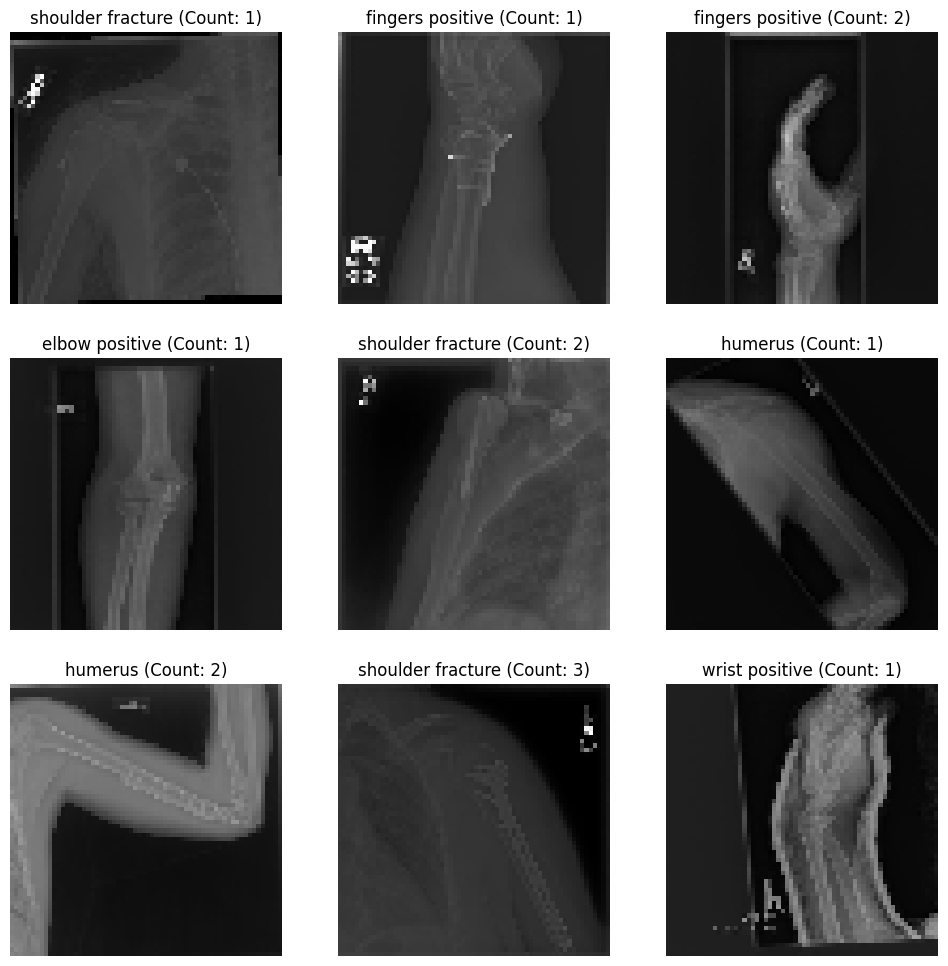


Class Distribution:
shoulder fracture: 3 images
fingers positive: 2 images
elbow positive: 1 images
humerus: 2 images
wrist positive: 1 images


In [ ]:
# Define class names (for labeling)
class_names = classes

# Initialize a counter to keep track of class occurrences
class_counter = Counter()

# Number of images to plot (you can adjust this)
num_images = min(len(images), 9)  # Plot up to 9 images

# Plot the sample of images
plt.figure(figsize=(12, 12))
for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1)  # Adjust grid dimensions if necessary
    plt.imshow(images[i].permute(1, 2, 0).numpy())  # Adjust image format for plotting

    # Extract the class index from the target dictionary (assuming 'labels' key exists)
    if 'labels' in target[i]:
        # Check if 'labels' is a tensor and extract the appropriate value
        if isinstance(target[i]['labels'], torch.Tensor):
            class_index = target[i]['labels'][0].item()  # Assuming the first element is the class index
        else:
            class_index = target[i]['labels']
    else:
        class_index = 0  # Default class index if 'labels' key is missing

    # Increment the class counter
    class_counter[class_names[class_index]] += 1

    # Set the title of the plot to the class name
    plt.title(f"{class_names[class_index]} (Count: {class_counter[class_names[class_index]]})")
    plt.axis("off")

plt.show()

# Print out the distribution of images per class
print("\nClass Distribution:")
for class_name, count in class_counter.items():
    print(f"{class_name}: {count} images")

* Correlation between Images and Target Class

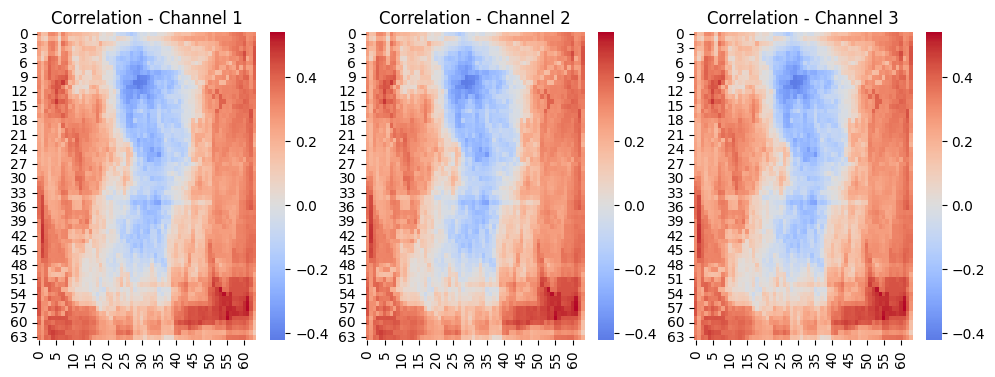

In [ ]:
# Convert the images tuple to a PyTorch tensor
images_tensor = torch.stack(images)

# Convert images to a numpy array
flattened_images = images_tensor.view(images_tensor.size(0), -1).numpy()

# Convert targets to a numpy array
target_classes = [t['labels'][0].item() if isinstance(t['labels'], torch.Tensor) else t['labels'] for t in target]
target_classes = np.array(target_classes)

# Compute correlation matrix between flattened image pixel intensities and target classes
correlation_matrix = np.corrcoef(flattened_images.T, target_classes)[:flattened_images.shape[1], -1]

# Calculate the correct dimensions for reshaping
num_channels = images_tensor.shape[1]  # Extract the number of color channels
side_length = int(np.sqrt(correlation_matrix.size / num_channels))  # Calculate side length assuming a square image for each channel

# Reshape correlation matrix to match the image shape per channel
correlation_image = correlation_matrix.reshape(num_channels, side_length, side_length)

# Plot the correlation image for each channel
plt.figure(figsize=(12, 4))
for channel in range(num_channels):
    plt.subplot(1, num_channels, channel + 1)
    sns.heatmap(correlation_image[channel], cmap='coolwarm', center=0)
    plt.title(f'Correlation - Channel {channel+1}')
plt.show()

* Interpretation of the Graphic: The graphic provides insight into which regions (or pixels) of the images are most correlated with predicting the target class.

* For example:

1. High positive correlations in certain regions suggest those areas are more predictive of the specific class (e.g., a fracture location).
2. Negative correlations suggest areas that might be less relevant or even inversely related to the class.